# Boolean Networks - Computer Practical

Focus: Network dynamics, state spaces, and predictive modeling

## Instructions for Students
- 🟢 **Code**: Code provided - run and observe
- 🟡 **TODO**: You need to complete these - look for TODO comments
- ❓ **Question**: Analysis questions you need to answer


In [1]:
# 🟢 Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### What are boolean networks?
Boolean networks are mathematical models where:
*   Each node has a binary state: ON (1) or OFF (0)
*   Nodes update based on Boolean rules (AND, OR, NOT)

### Why should you use Boolean Networks?
*   Handle discrete/categorical data naturally  
*   Model complex systems with simple rules
*   Find stable patterns (attractors) in data
*   Test 'what-if' scenarios (perturbation analysis)







---

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [2]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



## Part 1: Simple 3-node Boolean network

Let's first play with a simple 3-node example network

In [3]:
# 🟢 Helper class to build and simulate boolean network

print("Demo: Creating a simple 3-node Boolean network")

demo = BooleanNetwork(['A', 'B', 'C'])

# Add rules with clear descriptions
demo.add_rule('A', lambda state: not state['C'], "A = NOT C")
demo.add_rule('B', lambda state: state['A'] and state['C'], "B = A AND C")
demo.add_rule('C', lambda state: state['A'] or state['B'], "C = A OR B")

print("Rules:")
for node, rule_info in demo.rules.items():
    print(f"  {node}: {rule_info['description']}")

Demo: Creating a simple 3-node Boolean network
Rules:
  A: A = NOT C
  B: B = A AND C
  C: C = A OR B


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

In [4]:
# 🟢 Test simulation
demo.set_state(A=1, B=0, C=0)
print(f"\nStarting state: A=1, B=0, C=0")

trajectory = demo.simulate(steps=6)
print("Trajectory:")
for i, state in enumerate(trajectory):
    state_dict = {node: state[j] for j, node in enumerate(sorted(demo.nodes.keys()))}
    print(f"  Step {i}: A={state_dict['A']}, B={state_dict['B']}, C={state_dict['C']}")


Starting state: A=1, B=0, C=0
Trajectory:
  Step 0: A=1, B=0, C=0
  Step 1: A=1, B=0, C=1
  Step 2: A=0, B=1, C=1
  Step 3: A=0, B=0, C=1
  Step 4: A=0, B=0, C=0
  Step 5: A=1, B=0, C=0
  Step 6: A=1, B=0, C=1


❓ **Question**: What pattern do you observe?

*   Reaches stable state
*   Oscillates forever (TRUE)
*   Grows exponentially
*   Random behavior




---



## Part 2: Simplified cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [5]:
# 🟢 Create the regulatory network
import copy
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

# Assignment rules:
def apply_mutations(A=False, B=False, C=False, D=False):
    if A:  # Mutation A: p53 knockout
        network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
    if B:  # Mutation B: MYC amplification
        network.add_rule('MYC', lambda s: True,  "MYC = AMPLIFIED (always ON)")
    if C:  # Mutation C: MDM2 overexpression
        network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")

    # Mutation D: CDK2 activating mutation (always ON)
    if D:
        network.add_rule('CDK2', lambda s: True, "CDK2 = ACTIVATING MUTATION (always ON)")

print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

For each molecule, add a short description:
- e.g. MYC is suppressed by both p53 and p21
- p21 is activated by p53
- CDK2 is activated by MYC but suppressed by p21 and p53
- MDM2 is activated by MYC
- p53 suppressed by MDM2 but activated by DNA damage
- DNA damage is an input node (no regulators)
- Growth is activated by CDK2 and MYC but suppressed by p53
- Death is activated by p53 and DNA damage but suppressed by Growth

### Predict the outcomes
❓ **Question**: Before running simulations, make your predictions:

Scenarios:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`

For each scenario, decide on the final growth, death and p53 state (0 or 1).



In [6]:
base_network = copy.deepcopy(network)   # snapshot the pristine baseline

In [7]:
# 🟡 Example code for healthy cell below, adapt to also run Stressed Cell and Oncogene Hijacked Cell scenarios

scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

def run_scenario(network, scenario_name, initial_state, steps=8, verbose=True):
    network.set_state(**initial_state)
    trajectory = network.simulate(steps=steps)
    node_names = sorted(network.nodes.keys())
    final_state = trajectory[-1]
    final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
    if verbose:
        print(f"   {scenario_name}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")
    return trajectory, final_dict

mutation_combinations = [
    {'A': False, 'B': False, 'C': False, 'D': False},  # No mutation
    {'A': True,  'B': False, 'C': False, 'D': False},  # Mutation A
    {'A': False, 'B': True,  'C': False, 'D': False},  # Mutation B
    {'A': False, 'B': False, 'C': True,  'D': False},  # Mutation C
    {'A': False, 'B': False, 'C': False, 'D': True},   # Mutation D
]

node_names = sorted(network.nodes.keys())

for mut_idx, mut in enumerate(mutation_combinations):
    network = copy.deepcopy(base_network)  # Reset to original rules
    apply_mutations(**mut)
    print(f"\n--- Mutation Set {mut_idx+1}: {mut} ---")
    for scenario_name, initial_state in scenarios.items():
        trajectory, final_dict = run_scenario(network, scenario_name, initial_state, steps=8, verbose=True)
        results[(mut_idx, scenario_name)] = {'trajectory': trajectory, 'final': final_dict}

# TODO: Repeat for other scenarios!


--- Mutation Set 1: {'A': False, 'B': False, 'C': False, 'D': False} ---
   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 6 steps
   Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Reached steady state after 3 steps
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0

--- Mutation Set 2: {'A': True, 'B': False, 'C': False, 'D': False} ---
   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 4 steps
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 3 steps
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0

--- Mutation Set 3: {'A': False, 'B': True, 'C': False, 'D': False} ---
   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 7 steps
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Reached st

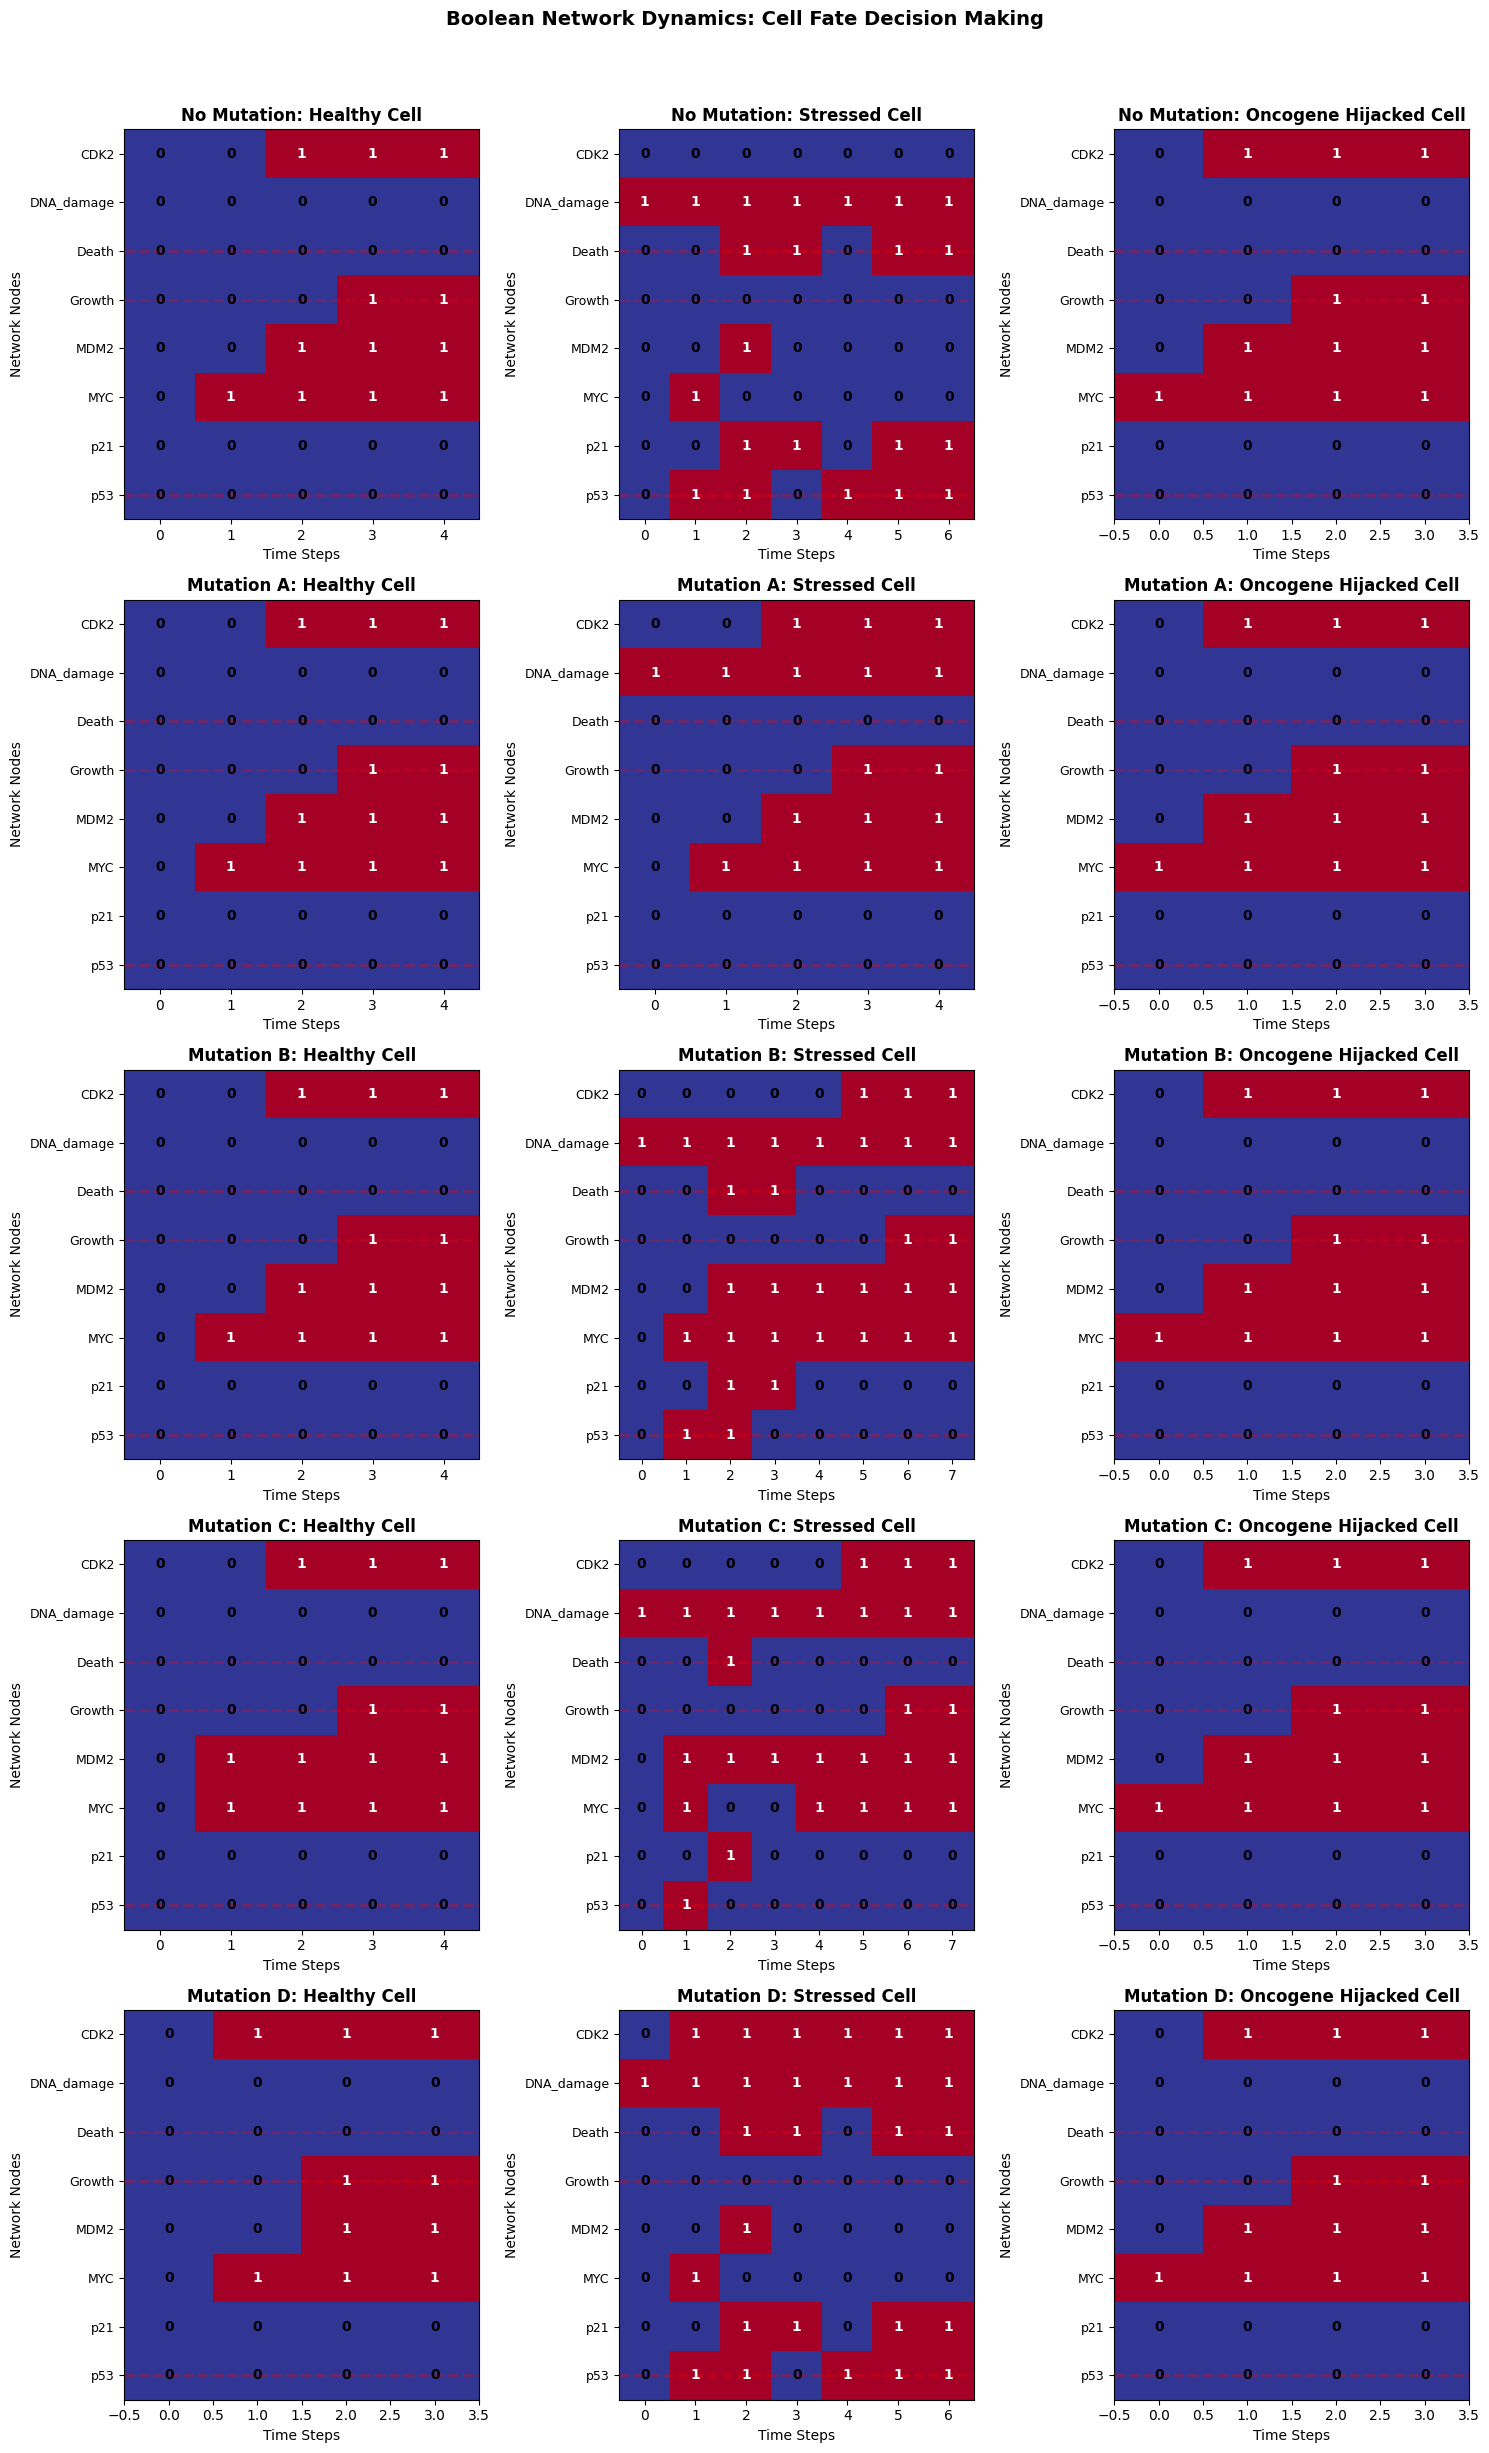

In [8]:
# 🟢 Visualize results
n_scenarios = len(results)
n_rows, n_cols = 5, 3
mutation_labels = ["No Mutation", "Mutation A", "Mutation B", "Mutation C", "Mutation D"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 24))

if n_scenarios == 1:
    axes = [axes]

for idx, ((mut_idx, scenario_name), data) in enumerate(results.items()):
    if idx >= n_rows * n_cols:
        break
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    trajectory = data['trajectory']
    trajectory_matrix = trajectory.T

    # Use custom mutation label (one label per 3 scenarios)
    mut_label = mutation_labels[mut_idx] if mut_idx < len(mutation_labels) else f"Mutation {mut_idx}"
    ax.set_title(f"{mut_label}: {scenario_name}", fontweight='bold', fontsize=12)

    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                    ha="center", va="center", color=color, fontweight='bold')

    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

# Hide unused subplots if any
total_plots = n_rows * n_cols
for empty_idx in range(len(results), total_plots):
    row = empty_idx // n_cols
    col = empty_idx % n_cols
    axes[row, col].axis('off')

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

❓ **Question**: Were your predictions for each scenario correct?
1. Which scenario leads to cell growth? for no muation
    * no mutation: Healthy Cell, Oncogene Hijacked Cell
    * Mutation A: Healthy Cell, Stressed Cell, Oncogene Hijacked Cell
    * Mutation B: Healthy Cell, Stressed Cell, Oncogene Hijacked Cell
    * Mutation C: Healthy Cell, Stressed Cell, Oncogene Hijacked Cell
    * Mutation D: Healthy Cell, Oncogene Hijacked Cell
2. Which scenario leads to cell death?
    * no mutation: Stressed Cell
    * Mutation A: None
    * Mutation B: None
    * Mutation C: None
    * Mutation D: Stressed Cell
3. How does p53 affect MYC?
    p53 suppresses MYC directly
4. What happens when there's no DNA damage?
    * no mutation: Growth
    * Mutation A: Growth
    * Mutation B: Growth
    * Mutation C: Growth
    * Mutation D: Growth


---

## **Part 3: Attractor analysis**

Attractors = stable states the network eventually reaches from any starting point

Types:
* Fixed Point: Network stops changing (steady state)
* Limit Cycle: Network oscillates in repeating pattern  

Why is this important?
* Represent system's natural 'destinations'
* Can predict long-term behavior
* Identify stable patterns in system
* Design interventions to reach desired attractors

❓ **Questions and interpretation**
1. How many total states did we test?
    we tested 256 states (2^8)
2. Why does the number of states grow so quickly?
    Because each node can be in 2 states (0 or 1), so for n nodes, there are 2^n possible states.
3. What would happen if we had 15 nodes instead of 8?
    it would be 32768 states (2^15)

---

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

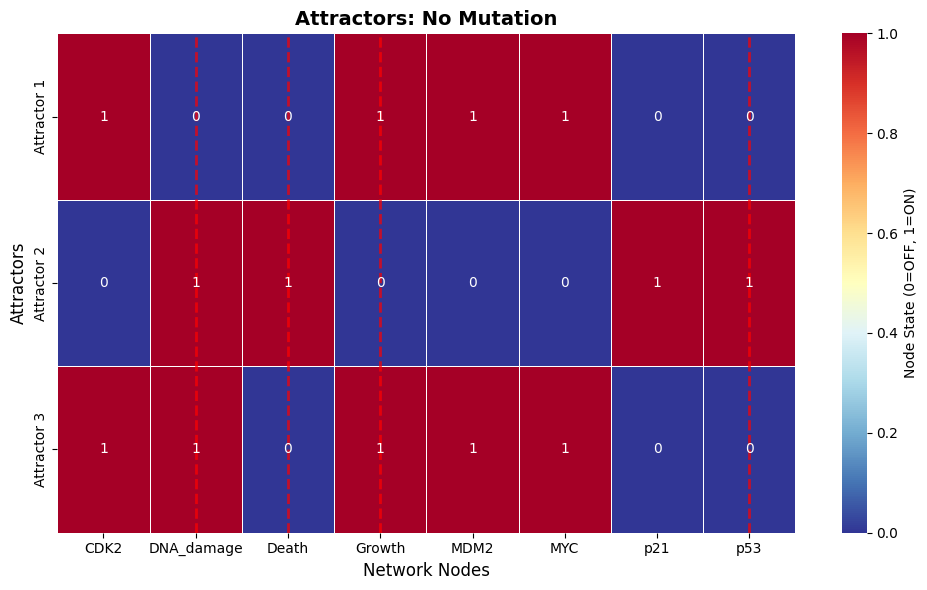

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

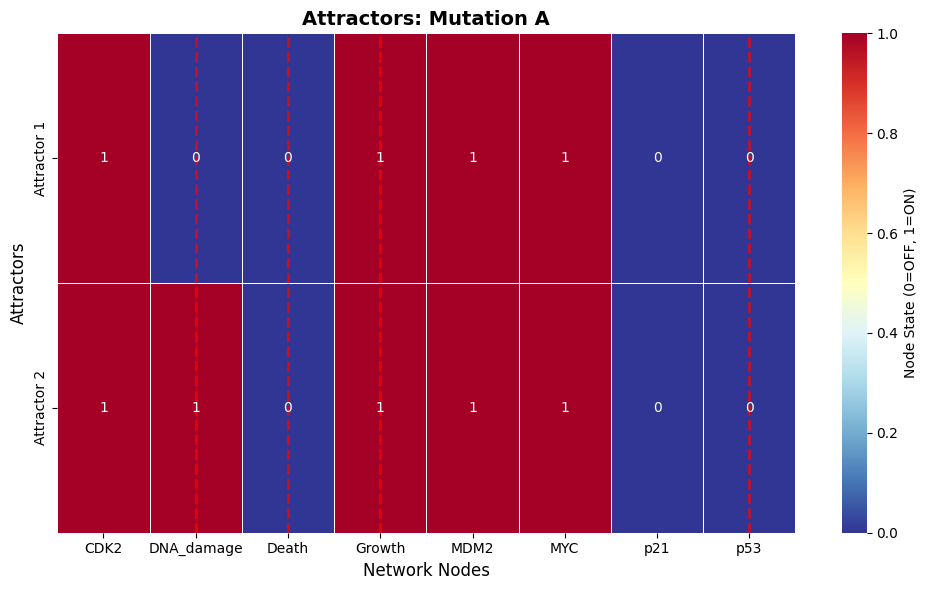

   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached s

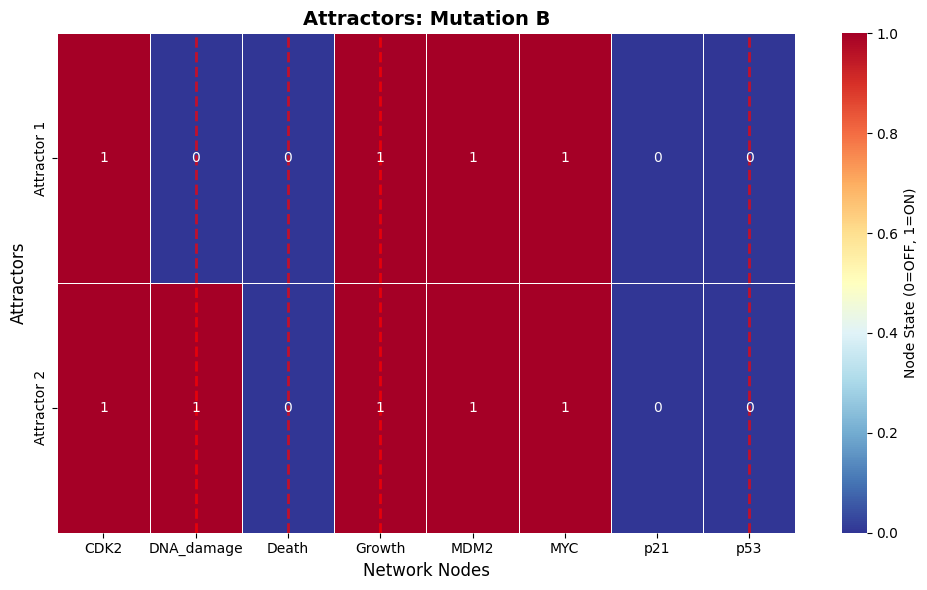

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

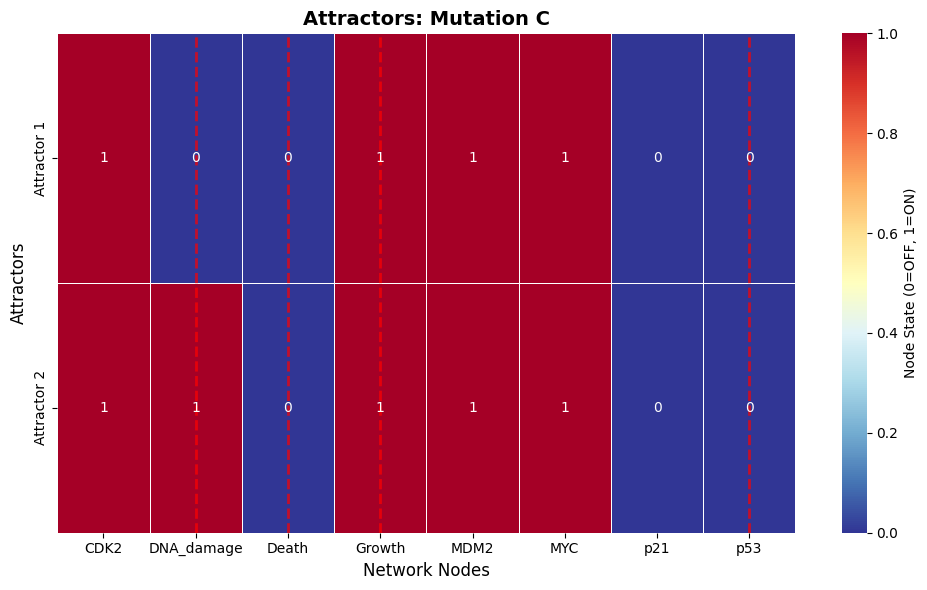

   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached s

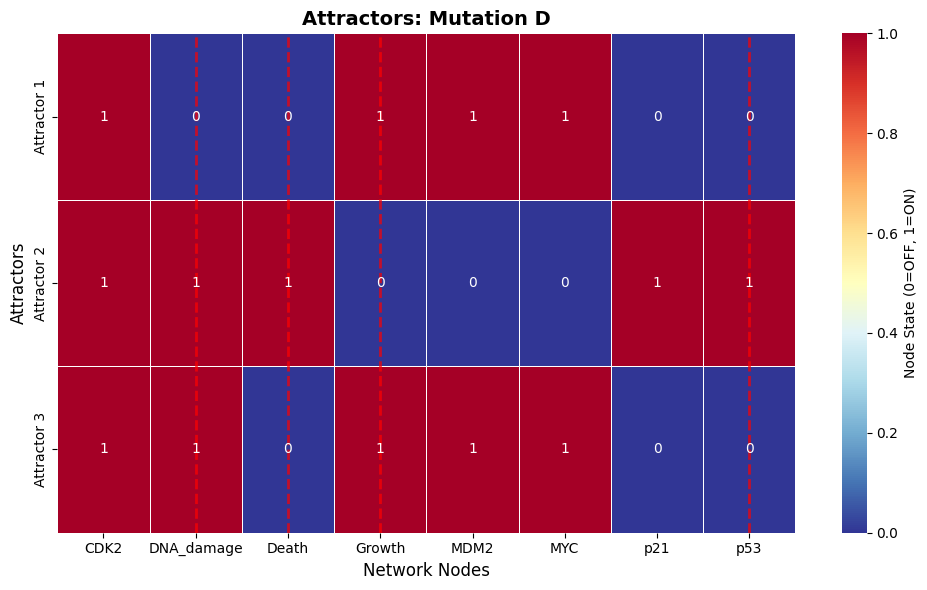

In [9]:
# 🟡 Let's find the attractor states
from itertools import product

for mut_idx, mut in enumerate(mutation_combinations):
    network = copy.deepcopy(base_network)  # Reset to original rules
    # Apply mutation
    apply_mutations(**mut)

    # Attractor analysis
    attractors = []
    max_steps = 15
    all_states = list(product([0, 1], repeat=len(node_names)))
    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(len(node_names))}
        network.set_state(**state_dict)
        trajectory = network.simulate(steps=max_steps, record_history=True)
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(trajectory[-1])
            if final_state not in attractors:
                attractors.append(final_state)

    # Prepare attractor matrix
    attractor_matrix = np.array([list(map(int, att)) for att in attractors])

    # Plot heatmap for this mutation scenario
    plt.figure(figsize=(10, max(6, len(attractors))))
    ax = sns.heatmap(attractor_matrix,
                     xticklabels=node_names,
                     yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                     cmap='RdYlBu_r',
                     cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                     annot=True,
                     fmt='d',
                     linewidths=0.5)
    plt.title(f'Attractors: {mutation_labels[mut_idx]}', fontsize=14, fontweight='bold')
    plt.xlabel('Network Nodes', fontsize=12)
    plt.ylabel('Attractors', fontsize=12)
    output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
    for node in output_nodes:
        if node in node_names:
            idx = node_names.index(node)
            ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.tight_layout()
    plt.show()


❓ **Questions and interpretation**
1. How many attractors did we find?
    * No mutation: 3 attractors
    * Mutation A: 2 attractors
    * Mutation B: 2 attractors
    * Mutation C: 2 attractors
    * Mutation D: 2 attractors
2. What does each attractor represent biologically?
    * in No mutation and muattion D:
        * Attractor 1: growth state (Growth=1, Death=0, p53=0)
        * Attractor 2: death state (Growth=0, Death=1, p53=1)
        * Attractor 3: cancerous state (Growth=1, Death=0, p53=0, DNA_damage=1)
    * in Mutation A, B, C:
        * Attractor 1: cancerous state (Growth=1, Death=0, p53=0, DNA_damage=1)
        * Attractor 2: growth state (Growth=1, Death=0, p53=0)
3. Which attractor represents a 'healthy' cell state and which one a cancerous' cell state?
    * cancerous state (Growth=1, Death=0, p53=0, DNA_damage=1)
    * healthy state (Growth=1, Death=0, p53=0, DNA_damage=0)


---





   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

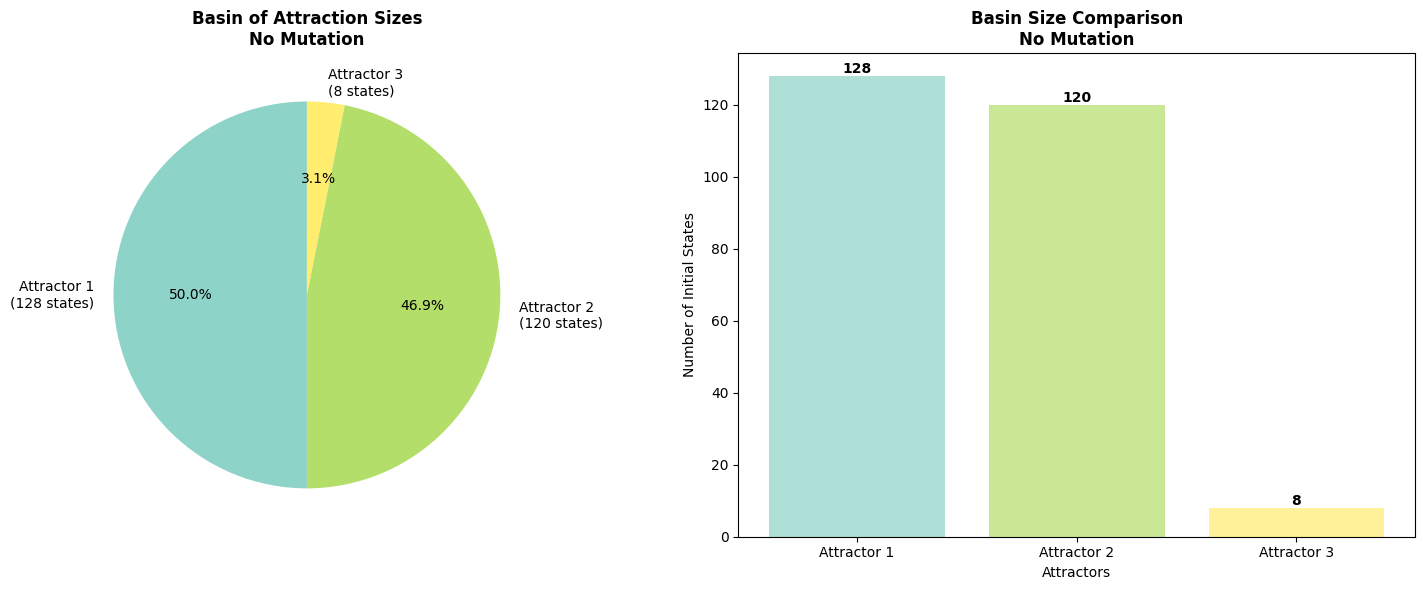

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

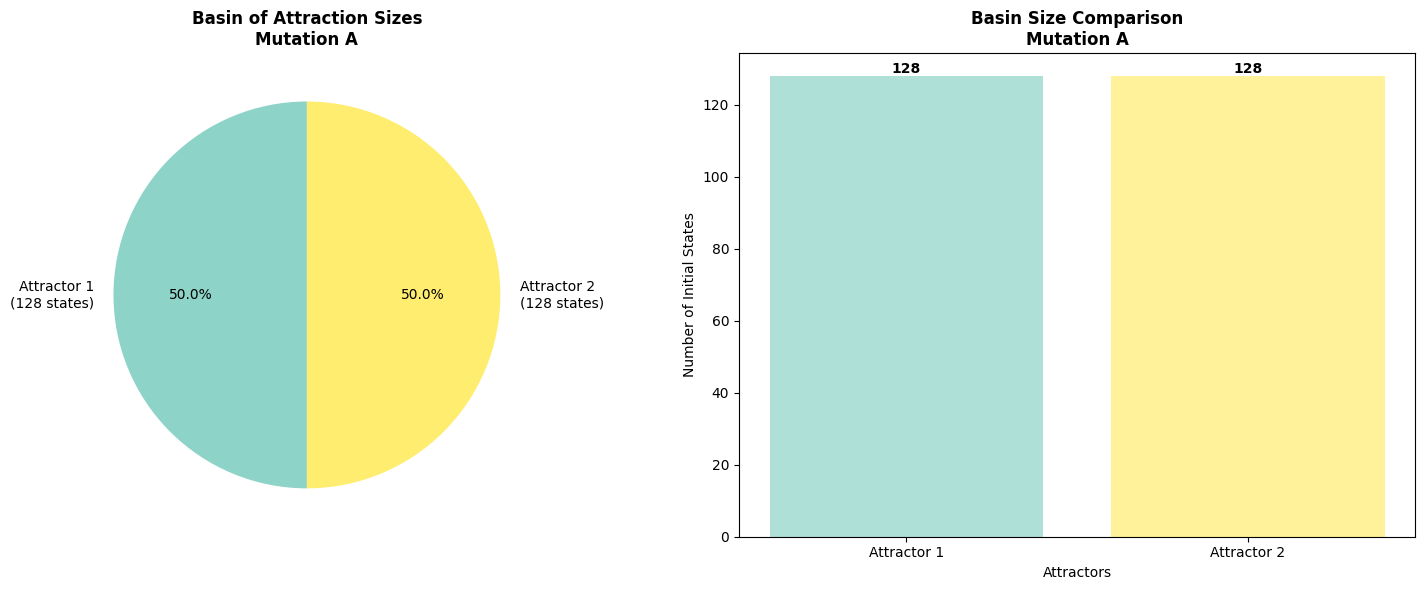

   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached s

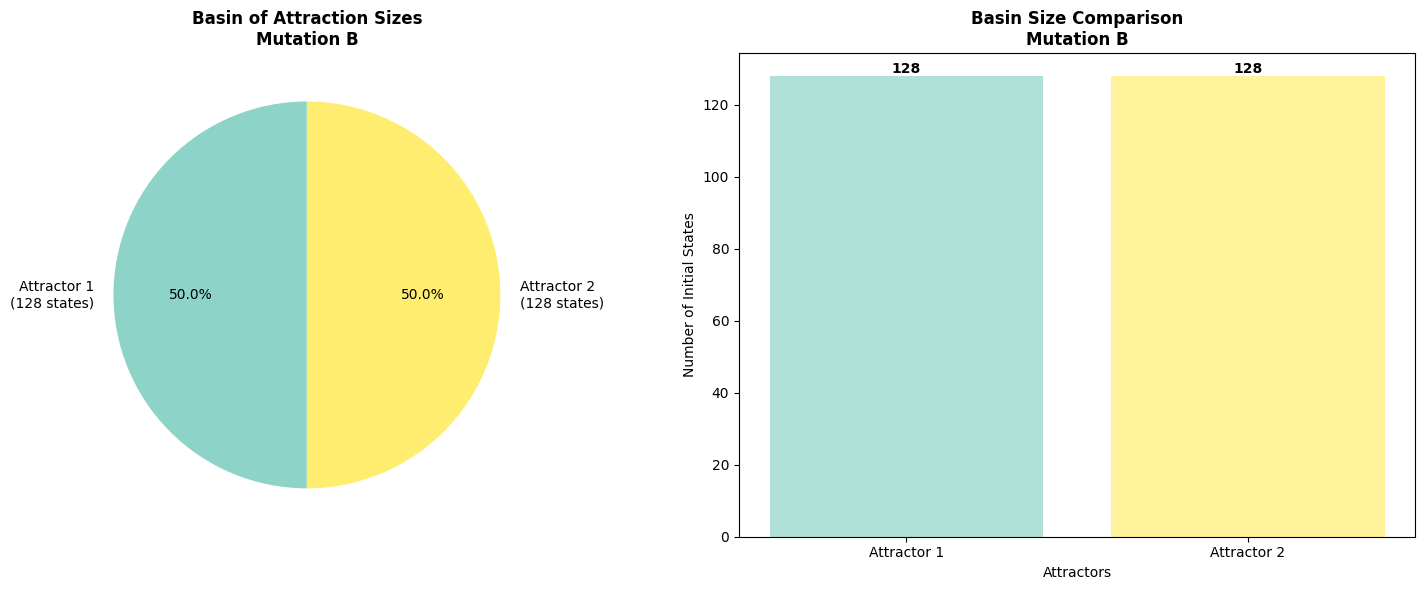

   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 3 steps
   Reached steady state after 6 steps
   Reached steady state after 5 steps
   Reached steady state after 6 steps
   Reached steady state after 4 steps
   Reached steady state after 6 steps
   Reached s

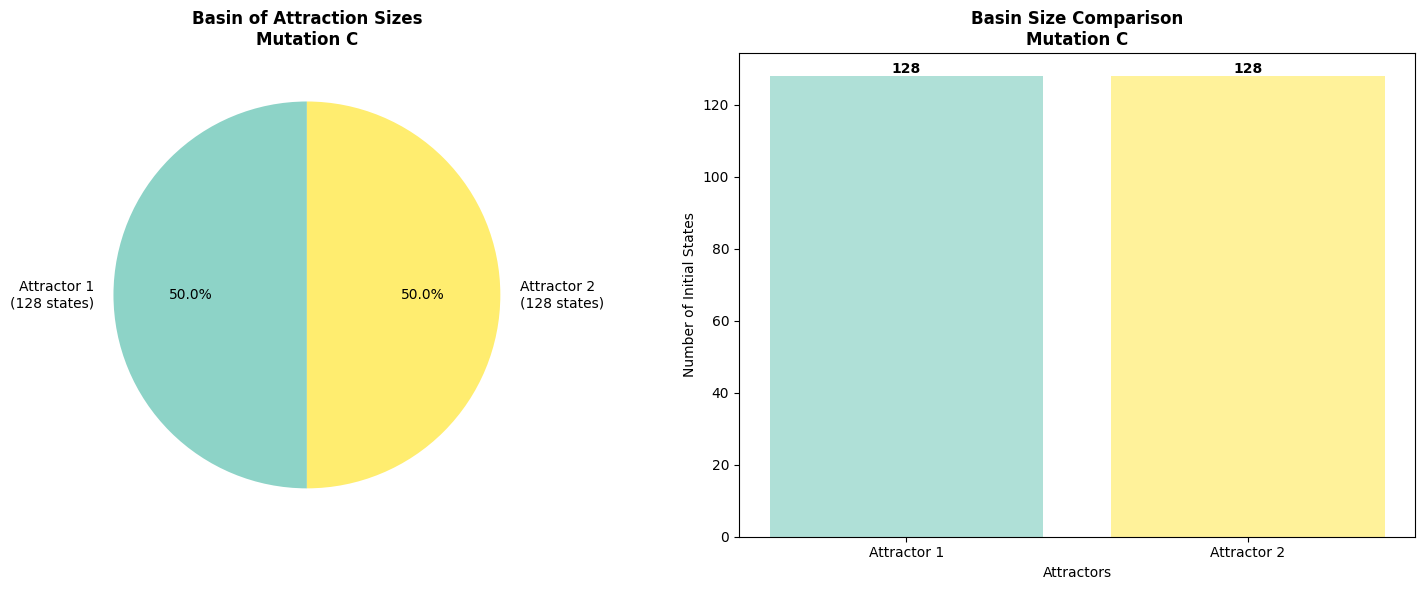

   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached s

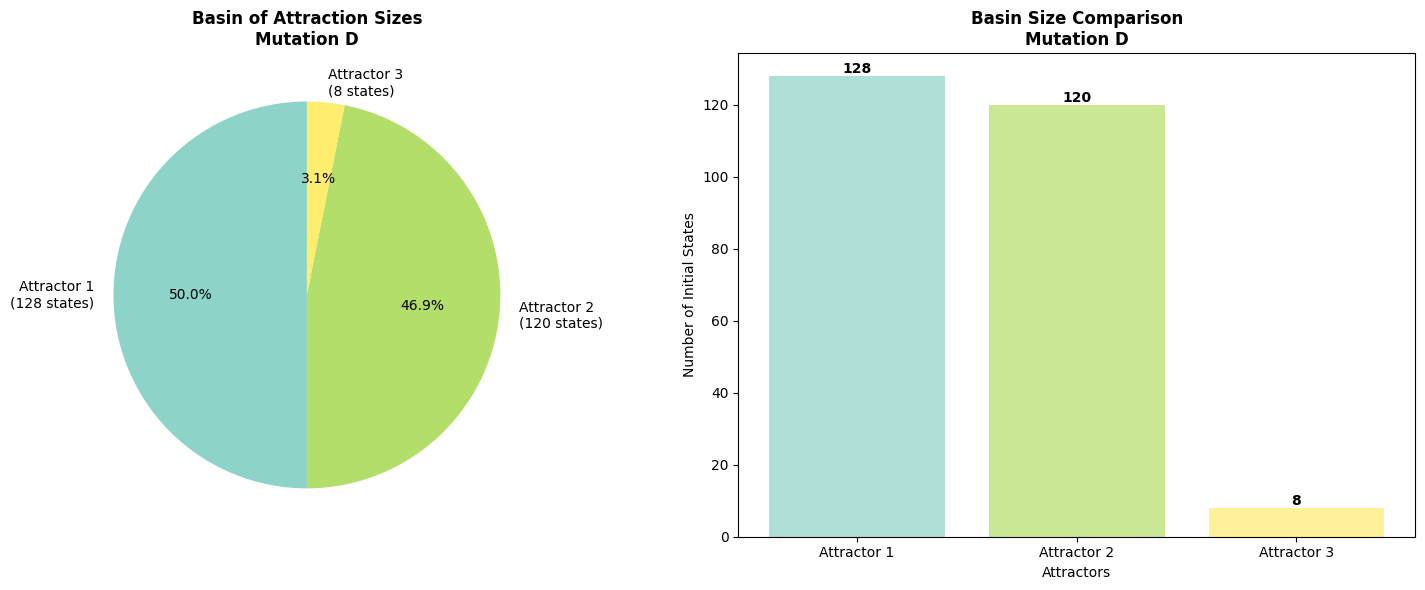

In [10]:
# 🟡 Which states end up in which attractor?

for mut_idx, mut in enumerate(mutation_combinations):
    network = copy.deepcopy(base_network)  # Reset to original rules
    # Apply mutation
    apply_mutations(**mut)

    # Find attractors
    attractors = []
    max_steps = 15
    all_states = list(product([0, 1], repeat=len(node_names)))
    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(len(node_names))}
        network.set_state(**state_dict)
        trajectory = network.simulate(steps=max_steps, record_history=True)
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(trajectory[-1])
            if final_state not in attractors:
                attractors.append(final_state)

    # Track which initial states lead to which attractor
    basin_data = defaultdict(list)
    attractor_map = {}
    for initial_state in all_states:
        state_dict = {node_names[i]: initial_state[i] for i in range(len(node_names))}
        network.set_state(**state_dict)
        trajectory = network.simulate(steps=max_steps, record_history=True)
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])
            for att_idx, attractor in enumerate(attractors):
                clean_attractor = tuple(int(x) for x in attractor)
                if final_state == clean_attractor:
                    basin_data[att_idx].append(initial_state)
                    attractor_map[initial_state] = att_idx
                    break

    # Plot basin sizes for this mutation scenario
    total_states = len(all_states)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
    basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
    colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

    ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title(f'Basin of Attraction Sizes\n{mutation_labels[mut_idx]}', fontsize=12, fontweight='bold')

    attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
    bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)
    ax2.set_title(f'Basin Size Comparison\n{mutation_labels[mut_idx]}', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Initial States', fontsize=10)
    ax2.set_xlabel('Attractors', fontsize=10)
    for bar, size in zip(bars, basin_sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


❓ **Questions and interpretation**
* How many initial states lead to each attractor?
    * No mutation and Mutation D:
        * Attractor 1: 128 states
        * Attractor 2: 120 states
        * Attractor 3: 8 states
    * Mutation A,B,C:
        * Attractor 1: 128 states
        * Attractor 2: 128 states
* Which attractors are most "popular" (large basins)?
    * No mutation and Mutation D: Attractor 1 (Growth state)
    * Mutation A,B,C: Both attractors equally popular (128 states each)


